
# Hyperparameter Optimization methods for CNNs using TensorFlow
---

## Setup

Import the libraries used throughout this notebook and configure reproducibility.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, BatchNormalization, concatenate
from keras.utils import to_categorical, normalize
from keras import optimizers
import random
import time

# set a random seed:

np.random.seed(5)

## Data loading and splitting

This notebook uses the **CIFAR-10 dataset**, which contains 60,000 color images
(32×32 pixels, 10 classes) commonly used for benchmarking image classification models.

Steps in this section:
1. Load CIFAR-10 from `keras.datasets`.
2. Split into **training** and **test** sets.
3. Inspect shapes to confirm that features and labels align.

**Checklist**
- Features `X` and labels `y` have matching lengths
- Train/validation/test proportions match the intended design
- No data leakage (test set isolated from any fitting)

In [2]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


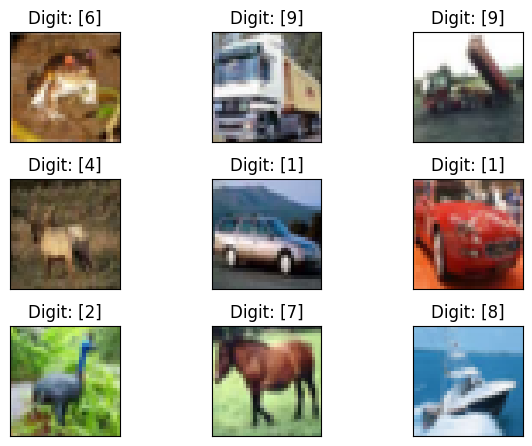

In [3]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], interpolation='none')
  plt.title("Digit: {}".format(Y_train[i]))
  plt.xticks([])
  plt.yticks([])

In [3]:
X_train.shape, Y_train.shape

((50000, 32, 32, 3), (50000, 1))

## Preprocessing
- **Feature scaling**: normalize/standardize inputs so gradients behave well and training converges faster.
- **Label encoding**: convert labels to categorical (for multi‑class softmax).

**Notes**
- Fit scalers on the *training* split only; apply to validation/test to avoid leakage.
- Keep track of the scaler object if you intend to serve the model later.

In [4]:
# features
X_train_norm = X_train.astype("float32") / 255.0
X_test_norm  = X_test.astype("float32")  / 255.0

#labels
y_train = Y_train.squeeze().astype("int32")
y_test  = Y_test.squeeze().astype("int32")

In [5]:
Y_train_cat = to_categorical(y_train, num_classes=10)
Y_test_cat = to_categorical(y_test, num_classes=10)

## Process

The experiment is done with two candidate neural network architectures selected from a prior notebook (Model A and Model B).  
The goal is to run a **randomized hyperparameter search** across both models, select the best configuration based on validation performance, explore different model behavior, and analyze results.

### Steps
1. Define the search space for each hyperparameter.
2. Sample random configurations and train/evaluate both models on the **same split**.
3. Track metrics and artifacts (best score, config, and notes).
4. Select the **best-performing model + hyperparameters** and explain the choice.
5. Train each model with the best hyperparameters and compare them.

### Hyperparameters to explore
- Optimization algorithm
- Learning rate
- Weight initialization
- Hidden-layer activation
- Dropout rate
- Hidden-layer width (neurons)
- Batch size

### Rationale
- **Optimizer & LR** drive convergence speed/stability.  
- **Initialization** affects early signal flow.  
- **Activation** shapes nonlinearity and gradient behavior.  
- **Dropout** regularizes to reduce overfitting.  
- **Width** trades capacity vs. overfitting/compute.  
- **Batch size** affects gradient noisee.

### Python lists for the search space:



In [6]:
optimizer    = ['SGD', 'RMSprop', 'Adam']
learn_rate   = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2]
init_mode    = ['he_uniform', 'he_normal', 'glorot_uniform', 'glorot_normal']
activation   = ['relu', 'tanh', 'sigmoid']
dropout_rate = [0.0, 0.1, 0.2, 0.3]
filters      = [32, 64]
batch_size   = [128, 256]



### Custom randomized search (manual loop)

Below, hyperparameters are sampled randomly, train for up to 30 epochs with early stopping
(on **validation accuracy**), and store the full history for each trial.

**What gets recorded per trial**
- sampled hyperparameters,
- per-epoch `accuracy` and `val_accuracy`,
- `best_val_accuracy` and the epoch where it occurred,
- batch size used.

Afterward, a **sorted summary** and **plots** of validation accuracy over epochs is displayed.

In [8]:
def random_search(
    build_fn,  # your model builder (e.g. network or func_network)
    optimizer_choices,
    lr_choices,
    init_choices,
    activation_choices,
    dropout_choices,
    filter_choices,
    batch_choices,
    n_trials=10,
    epochs=30,
    val_split=0.2,
    patience=3,
):
    """
    Perform a custom random hyperparameter search.

    Returns:
        histories: list of dicts with training/validation accuracy per trial
        results: list of (trial, hyperparams, final_train_acc, final_val_acc)
    """
    histories = []
    results = []

    for i in range(1, n_trials + 1):
        # Sample random hyperparameters
        hp = {
            "optimizer": random.choice(optimizer_choices),
            "learn_rate": random.choice(lr_choices),
            "init_mode": random.choice(init_choices),
            "activation": random.choice(activation_choices),
            "dropout_rate": random.choice(dropout_choices),
            "filters": random.choice(filter_choices),
            "batch_size": random.choice(batch_choices),
        }

        print(f"\n{i} Training with: {hp}")

        # Build model
        model = build_fn(
            hp["optimizer"], hp["learn_rate"], hp["init_mode"],
            hp["activation"], hp["dropout_rate"], hp["filters"]
        )

        callback = tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy", patience=patience,
            mode="max", restore_best_weights=True, verbose=0
        )

        th = TimeHistory()

        h = model.fit(
            X_train_norm, Y_train_cat,
            batch_size=hp["batch_size"],
            epochs=epochs,
            validation_split=val_split,
            callbacks=[callback, th], # Added th to the callbacks list
            verbose=0,
        )

        run_results = {
            "train_acc": h.history["accuracy"],
            "val_acc": h.history["val_accuracy"],
        }

        final_train = run_results["train_acc"][-1]
        final_val = run_results["val_acc"][-1]

        mean_epoch_s = float(np.mean(th.epoch_times))
        total_s = float(th.total_time)

        print(f"Final train acc: {final_train:.4f} | Final val acc: {final_val:.4f} "
              f"| time: {total_s:.1f}s (~{mean_epoch_s:.2f}s/epoch)")

        histories.append(run_results)
        results.append((i, hp, final_train, final_val))

    return histories, results

def plot_histories(histories, title="Train vs Validation Accuracy"):
    """
    Plot training and validation accuracy curves for all trials.

    Args:
        histories (list of dict): Output from random_search, each dict has
                                  "train_acc" and "val_acc".
        title (str): Plot title
    """
    plt.figure(figsize=(12, 8))

    for i, h in enumerate(histories, 1):
        train_curve = np.asarray(h["train_acc"])
        val_curve = np.asarray(h["val_acc"])

        # Training curve (dashed)
        plt.plot(train_curve, linestyle="--", alpha=0.7, label=f"Train {i}")
        # Validation curve (solid)
        plt.plot(val_curve, alpha=0.9, label=f"Val {i}")

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_final_acc(results, title="Final Train vs Validation Accuracy"):
    """
    Plot final train and validation accuracy as bars for each trial.

    Args:
        results (list of tuples): (trial, hp, final_train, final_val)
    """
    trials = [r[0] for r in results]
    train_acc = [r[2] for r in results]
    val_acc = [r[3] for r in results]

    x = np.arange(len(trials))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, train_acc, width, label="Train Acc", alpha=0.7)
    plt.bar(x + width/2, val_acc, width, label="Val Acc", alpha=0.9)

    plt.xticks(x, [f"T{i}" for i in trials])
    plt.ylim(0, 1.0)
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
        self._t0_total = time.perf_counter()
    def on_epoch_begin(self, epoch, logs=None):
        self._t0_epoch = time.perf_counter()
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_times.append(time.perf_counter() - self._t0_epoch)
    def on_train_end(self, logs=None):
        self.total_time = time.perf_counter() - self._t0_total

### Model A: Simple CNN (for hyperparameter search)

Define a compact **Sequential** convolutional network to keep trials fast and comparable.  
The hyperparameters exposed for search are:

- `optimizer` and `learn_rate`
- `init_mode` (weight initializer)
- `activation` (hidden layers)
- `dropout_rate`
- `filters` (number of conv filters per block)

**Architecture (in order)**
1. `Conv2D → BatchNorm → Dropout` (3×3)
2. `Conv2D → BatchNorm → Dropout` (3×3) → `MaxPooling2D`
3. `Conv2D → BatchNorm → Dropout` (5×5) → `MaxPooling2D`
4. `Flatten`
5. `Dense(64, activation=<activation>)`
6. `Dense(10, activation='softmax')`

> Notes:
> - We apply the same `init_mode` consistently to conv and dense layers.
> - Use `categorical_crossentropy` (one-hot labels) or switch to `sparse_categorical_crossentropy` if labels are integers.
> - Keep input shape fixed at `(32, 32, 3)` for CIFAR-like images.

In [9]:
def network(optimizer, learn_rate, init_mode,
            activation, dropout_rate,
            filters):
  """
       The hyperparameters to search are listed as variables;
       Below are three Conv layers followed each by batch normalization
       dropout layers;

       Pooling layers were added two times;

       A dense layer with a preset number or filters, 64
       and activation function relu;

       the output dense layer with 10 filters and softmax activation
  """
  model = Sequential()

  model.add(Conv2D(filters, (3,3), activation = activation,
                   input_shape = (32,32,3), kernel_initializer=init_mode))
  model.add(BatchNormalization())
  model.add(Dropout(rate=dropout_rate))

  model.add(Conv2D(filters, (3,3), activation = activation))
  model.add(BatchNormalization())
  model.add(Dropout(rate=dropout_rate))
  model.add(MaxPool2D(2,2))

  model.add(Conv2D(filters, (5,5), activation = activation))
  model.add(BatchNormalization())
  model.add(Dropout(rate = dropout_rate))
  model.add(MaxPool2D(2,2))

  model.add(Flatten())

  model.add(Dense(64, activation = activation))
  model.add(Dense(10, activation = 'softmax'))


  model.compile(optimizer = optimizer,
                loss = 'categorical_crossentropy', metrics = ['accuracy'] )

  """
  The print hyperparameters found in the search
  """
  print('Optimizer: ' + optimizer+' ',
        'Learning rate: ' + str(learn_rate) + ' ',
       'Initiation mode: ' + init_mode +' ',
        'Activation: ' + activation +' ',
       'Dropout rate: ' + str(dropout_rate)+' ',
       'Number of filters: '+ str(filters))

  return model

### Random search

In [10]:
histories_seq, results_seq = random_search(
    build_fn=network,
    optimizer_choices=optimizer,
    lr_choices=learn_rate,
    init_choices=init_mode,
    activation_choices=activation,
    dropout_choices=dropout_rate,
    filter_choices=filters,
    batch_choices=batch_size,
    n_trials=10
)


1 Training with: {'optimizer': 'Adam', 'learn_rate': 0.003, 'init_mode': 'glorot_normal', 'activation': 'tanh', 'dropout_rate': 0.2, 'filters': 32, 'batch_size': 256}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Optimizer: Adam  Learning rate: 0.003  Initiation mode: glorot_normal  Activation: tanh  Dropout rate: 0.2  Number of filters: 32
Final train acc: 0.7376 | Final val acc: 0.5642 | time: 61.6s (~3.62s/epoch)

2 Training with: {'optimizer': 'SGD', 'learn_rate': 0.001, 'init_mode': 'he_normal', 'activation': 'tanh', 'dropout_rate': 0.2, 'filters': 64, 'batch_size': 256}
Optimizer: SGD  Learning rate: 0.001  Initiation mode: he_normal  Activation: tanh  Dropout rate: 0.2  Number of filters: 64
Final train acc: 0.4791 | Final val acc: 0.2246 | time: 35.2s (~8.80s/epoch)

3 Training with: {'optimizer': 'Adam', 'learn_rate': 0.01, 'init_mode': 'he_uniform', 'activation': 'sigmoid', 'dropout_rate': 0.1, 'filters': 64, 'batch_size': 128}
Optimizer: Adam  Learning rate: 0.01  Initiation mode: he_uniform  Activation: sigmoid  Dropout rate: 0.1  Number of filters: 64
Final train acc: 0.8535 | Final val acc: 0.6864 | time: 69.1s (~6.28s/epoch)

4 Training with: {'optimizer': 'SGD', 'learn_rate': 0.

### Visualization of results
- Plotting the learning curves of all the random models:

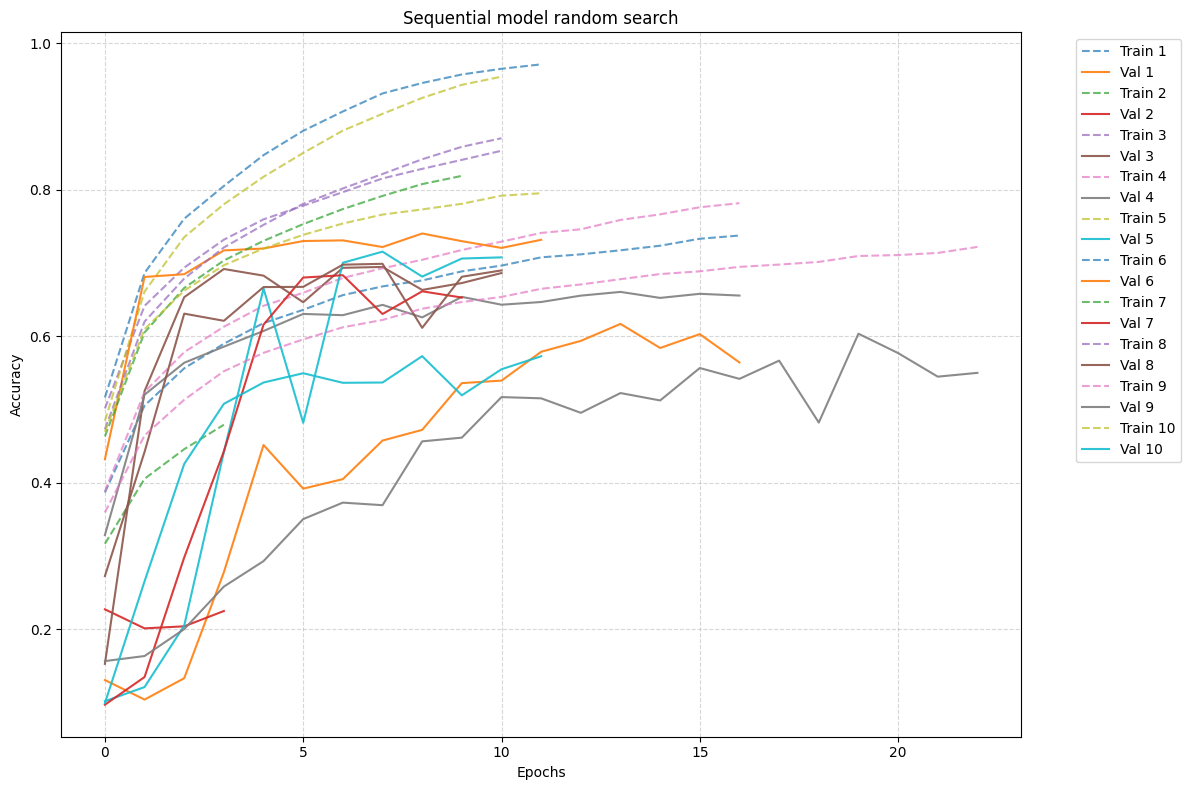

In [11]:
plot_histories(histories_seq, title="Sequential model random search")

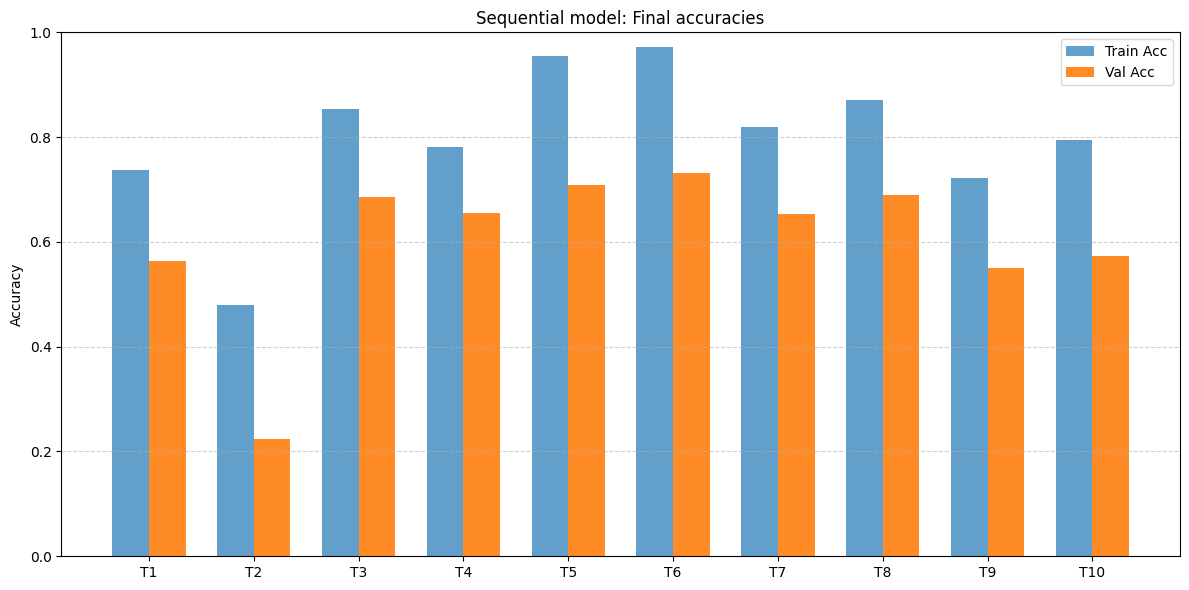

In [12]:
plot_final_acc(results_seq, title="Sequential model: Final accuracies")

## Results and Conclusion

### Outcomes
> Training accuracy often exceeded validation accuracy → signs of **overfitting**.

### Overfitting & Generalization Gap (summary)

**Idea.** Overfitting = training accuracy rises while validation/test lag.  
**Gap metric.** `gap = final_train_acc − best_val_acc` (smaller = better generalization).

### Model A (top trials w/ time)

| Trial | Val Acc | Train Acc | Gap  | Time (total) | ~s/epoch |
|-----:|--------:|----------:|-----:|-------------:|---------:|
| 6 | **0.7318** | 0.9715 | **0.240** | 73.4s | 6.11 |
| 5 | 0.7078 | 0.9547 | 0.247 | 60.6s | 5.51 |
| 8 | 0.6900 | 0.8705 | 0.181 | 33.7s | 3.06 |
| 3 | 0.6864 | 0.8535 | 0.167 | 69.1s | 6.28 |
| 4 | 0.6556 | 0.7818 | **0.126** | 61.5s | 3.62 |

*Times reflect early stopping; per-epoch values are approximate.*

### Key takeaway — Model A

- **Best accuracy:**
  > **Trial 6** — *RMSprop, lr=1e-4, He-uniform, ReLU, dropout=0.0, 64 filters, batch=128* → **val ≈ 0.732**, but with a **larger gap (~0.24)**.
- **Better balance (smaller gap):**  
  - **Trial 3** — *Adam, lr=1e-2, He-uniform, **sigmoid**, drop=0.1, 64f* → **val ≈ 0.686**, gap ≈ **0.167**.  
  - **Trial 8** — *RMSprop, lr=1e-4, He-uniform, ReLU, drop=0.0, 32f* → **val ≈ 0.690**, gap ≈ **0.181**, and **fastest total time**.
  - **Trial 4** — *SGD, lr=3e-4, He-normal, ReLU, drop=0.0, 32f* → **val ≈ 0.656**, **smallest gap (~0.126)** among top-5.
- **Optimizers & LR:**
  > In this batch, **RMSprop @ 1e-4** topped accuracy; **Adam @ 1e-2** also strong. Very low-LR **SGD** underperformed in Trial 2.
- **Regularization:**
  > With BatchNorm, **light/no dropout (0–0.1)** dominated the best runs.
- **Capacity:**
  > **32–64 filters** were sufficient; tuning **optimizer/LR** mattered more than width.
- **Speed vs params:**
  > Fewer params ≠ faster; **convs before pooling** dominate FLOPs, so runs with more high-resolution conv work can be slower per epoch.



## Model B: Functional CNN

In the previous section, we used a simple Sequential model.  
Here, we redefine the network with Keras’ **Functional API**, which allows more flexible architectures.

### Architecture
- Two parallel convolutional branches:
  - Conv(3×3) → BatchNorm → Dropout → MaxPooling → Flatten
  - Conv(5×5) → BatchNorm → Dropout → MaxPooling → Flatten
- The two flattened outputs are concatenated
- Dense(64, relu)
- Dense(10, softmax)

This design lets the network learn from **different receptive field sizes** (3×3 and 5×5) and combine them before classification.

In [24]:
def func_network(optimizer, learn_rate, init_mode,
            activation, dropout_rate,
            filters):

  inputs = Input(shape=(32,32,3))

  """
        Two parallel conv branches (3×3 and 5×5), each with
        BatchNorm, Dropout, and MaxPooling. Flattened outputs
        are concatenated, followed by Dense(64, relu) and
        a Dense(10, softmax) classifier.
  """

  x = Conv2D(filters,(3,3), activation=activation,
             kernel_initializer = init_mode)(inputs)
  x1 = BatchNormalization()(x)
  x2 = Dropout(rate=dropout_rate)(x1)
  x3 = MaxPool2D(2,2)(x2)
  x4 = Flatten()(x3)


  y = Conv2D(filters,(5,5), activation=activation,
            kernel_initializer = init_mode)(inputs)
  y1 = BatchNormalization()(y)
  y2 = Dropout(rate=dropout_rate)(y)
  y3 = MaxPool2D(2,2)(y2)
  y4 = Flatten()(y3)


  a = concatenate([x4, y4])


  dense = Dense(64, activation = 'relu')(a)

  outputs = Dense(10, activation = 'softmax')(dense)

  func_model = Model(inputs, outputs)

  func_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  """
  print hyperparameters found in the search
  """
  print('Optimizer: ' + optimizer+' ',
        'Learning rate: ' + str(learn_rate) + ' ',
       'Initiation mode: ' + init_mode +' ',
        'Activation: ' + activation +' ',
       'Dropout rate: ' + str(dropout_rate)+' ',
       'Number of filters: '+ str(filters))

  return func_model

### Randomized hyperparameter search (manual loop)

The same manual random-search procedure as in Model A is repeated here, but using the functional architecture.
Each trial samples hyperparameters, trains with early stopping, and records the learning curve.

In [25]:
histories_func, results_func = random_search(
    build_fn=func_network,
    optimizer_choices=optimizer,
    lr_choices=learn_rate,
    init_choices=init_mode,
    activation_choices=activation,
    dropout_choices=dropout_rate,
    filter_choices=filters,
    batch_choices=batch_size,
    n_trials=10
)


1 Training with: {'optimizer': 'RMSprop', 'learn_rate': 0.003, 'init_mode': 'he_uniform', 'activation': 'sigmoid', 'dropout_rate': 0.0, 'filters': 32, 'batch_size': 128}
Optimizer: RMSprop  Learning rate: 0.003  Initiation mode: he_uniform  Activation: sigmoid  Dropout rate: 0.0  Number of filters: 32
Final train acc: 0.7802 | Final val acc: 0.5996 | time: 29.6s (~2.69s/epoch)

2 Training with: {'optimizer': 'Adam', 'learn_rate': 0.003, 'init_mode': 'he_uniform', 'activation': 'sigmoid', 'dropout_rate': 0.2, 'filters': 64, 'batch_size': 256}
Optimizer: Adam  Learning rate: 0.003  Initiation mode: he_uniform  Activation: sigmoid  Dropout rate: 0.2  Number of filters: 64
Final train acc: 0.5719 | Final val acc: 0.4244 | time: 71.8s (~4.78s/epoch)

3 Training with: {'optimizer': 'RMSprop', 'learn_rate': 0.01, 'init_mode': 'he_normal', 'activation': 'tanh', 'dropout_rate': 0.1, 'filters': 32, 'batch_size': 128}
Optimizer: RMSprop  Learning rate: 0.01  Initiation mode: he_normal  Activatio

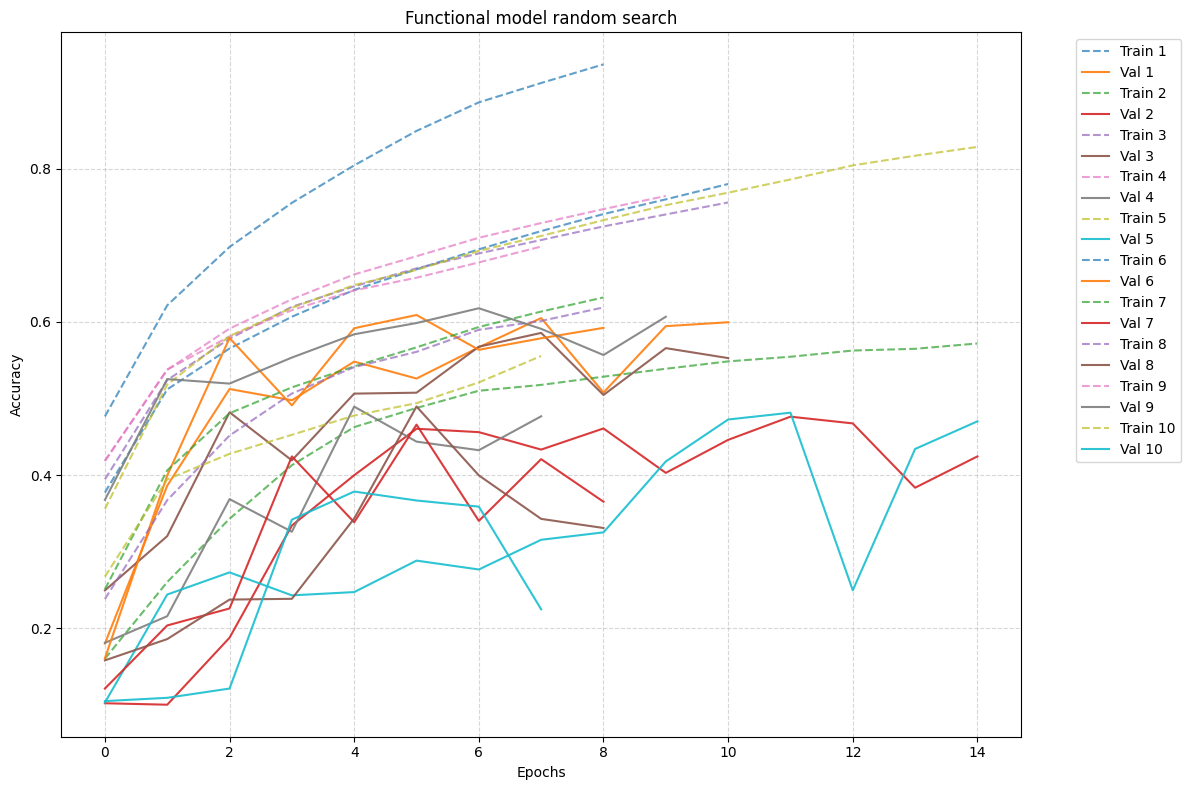

In [26]:
plot_histories(histories_func, title="Functional model random search")

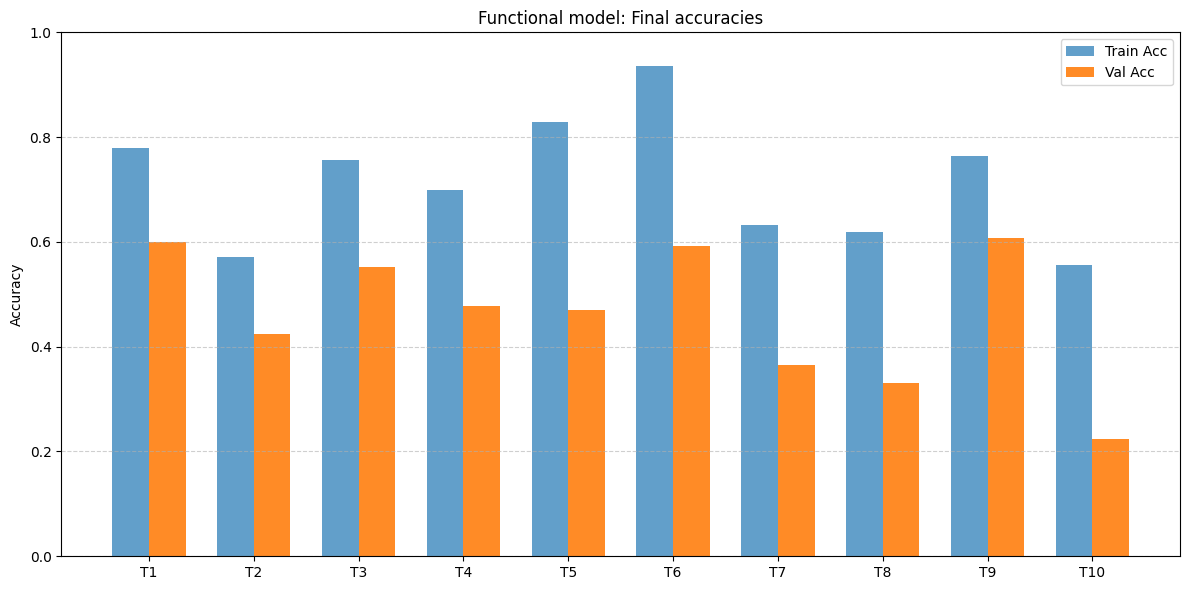

In [27]:
plot_final_acc(results_func, title="Functional model: Final accuracies")

## Model B — Results

**Overfitting check:**

> Most runs show train > val. Use the **gap = train − val** to judge generalization.

### Top by validation accuracy
| Trial | Val Acc | Train Acc | Gap | Time (total) |
|---:|---:|---:|---:|---:|
| 9 | **0.6068** | 0.7645 | **0.158** | 30.8s (~3.08s/epoch) |
| 1 | 0.5996 | 0.7802 | 0.181 | 29.6s (~2.69s/epoch) |
| 6 | 0.5923 | 0.9365 | 0.344 | 23.5s (~2.60s/epoch) |
| 3 | 0.5528 | 0.7560 | 0.203 | 34.1s (~3.10s/epoch) |

**Underperformers (low val / large gap):**  

> Trials 5, 6, 7, 8, 10 show clear overfitting (gaps ≈ 0.27–0.36) and/or low validation accuracy (≤ 0.48).

---

## Key takeaways (Model B)

- **Best accuracy:**
  > Trial 9 (SGD, lr=3e-4, He-uniform, ReLU, drop=0.1, 32 filters, batch=128) with ~ 0.607 val acc and a moderate gap (~0.158).
- **Close second:**
  > Trial 1 (RMSprop, 3e-3, sigmoid, no dropout, 32f) at ~0.600 val, slightly larger gap.
- **Fast but overfitting:**
  > Trial 6 trained quickest yet had a large gap (~0.344) → strong overfit warning.
- **General trend:**
  >32 filters with ReLU or tanh and moderate LRs work better; very confident training (high train acc) without matching val acc = overfit.

- **Pick:**

  >To prioritize max val accuracy, choose Trial 9.  
  For similar accuracy with simpler training, Trial 1 is acceptable.  



# Training best variants



In [13]:
# === Reusable utilities ===

def summarize_and_plot_model(model, filename="model.png", dpi=110):
    """Print a text summary and save/display a model diagram."""
    model.summary()
    plot_model(model, to_file=filename, show_shapes=True, show_layer_names=True, dpi=dpi)
    display(Image(filename=filename, retina=True))

def default_callbacks(patience=5, monitor="val_accuracy", ckpt_path="best_model.weights.h5"):
    """Standard callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint (weights only)."""
    cbs = [
        tf.keras.callbacks.EarlyStopping(
            monitor=monitor, patience=patience, mode="max", restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor=monitor, factor=0.5, patience=max(2, patience//2), min_lr=1e-5, mode="max", verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=ckpt_path, monitor=monitor, mode="max",
            save_best_only=True, save_weights_only=True, verbose=0
        ),
    ]
    return cbs

def train_model(model, X_train, y_train, *, batch_size=128, epochs=200,
                val_split=0.2, callbacks=None, verbose=1):
    """Fit a model and return the History object."""
    callbacks = callbacks or default_callbacks()
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=val_split,
        callbacks=callbacks,
        verbose=verbose
    )
    return history

def plot_history(history, title_prefix="Model"):
    """Plot train/val accuracy and loss (if available)."""
    H = history.history
    # Accuracy
    if "accuracy" in H and "val_accuracy" in H:
        plt.figure(figsize=(6,4))
        plt.plot(H["accuracy"], label="Train acc", linestyle="--")
        plt.plot(H["val_accuracy"], label="Val acc")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(f"{title_prefix} accuracy")
        plt.legend(); plt.grid(alpha=0.4); plt.tight_layout(); plt.show()
    # Loss
    if "loss" in H and "val_loss" in H:
        plt.figure(figsize=(6,4))
        plt.plot(H["loss"], label="Train loss", linestyle="--")
        plt.plot(H["val_loss"], label="Val loss")
        plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{title_prefix} loss")
        plt.legend(); plt.grid(alpha=0.4); plt.tight_layout(); plt.show()

def evaluate_model(model, X_test, y_test, *, verbose=0):
    """Evaluate on test data and print nicely."""
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=verbose)
    print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")
    return test_loss, test_acc


## Model A

In [14]:
# --- Model A (Sequential) final run with bestA ---

from IPython.display import Image
# Trial 6 — RMSprop, lr=1e-4, He-uniform, ReLU, dropout=0.0, 64 filters, batch=128 → val ≈ 0.732, but with a larger gap (~0.24).
bestA = {
    "optimizer": "RMSprop",
    "learn_rate": 1e-4,
    "init_mode": "he_uniform",
    "activation": "relu",
    "dropout_rate": 0.0,
    "filters": 64,
    "batch": 128,
}

# 1) Build the model with your builder
modelA = network(
    bestA["optimizer"],
    bestA["learn_rate"],
    bestA["init_mode"],
    bestA["activation"],
    bestA["dropout_rate"],
    bestA["filters"]
)

# Ensure the learning rate is actually applied
opt = tf.keras.optimizers.get(
    {"class_name": bestA["optimizer"], "config": {"learning_rate": bestA["learn_rate"]}}
)
# keep current loss/metrics, just swap optimizer to ensure LR is set
modelA.compile(optimizer=opt, loss=modelA.loss, metrics=['accuracy'])

# Callbacks
cbs = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, mode="max", restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-5, mode="max", verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath="modelA_best.weights.h5", monitor="val_accuracy",
                                       mode="max", save_best_only=True, save_weights_only=True)
]

# Model summary
modelA.summary()

Optimizer: RMSprop  Learning rate: 0.0001  Initiation mode: he_uniform  Activation: relu  Dropout rate: 0.0  Number of filters: 64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 10, 10, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,066 (957.29 KB)

 Trainable params: 244,682 (955.79 KB)

 Non-trainable params: 384 (1.50 KB)

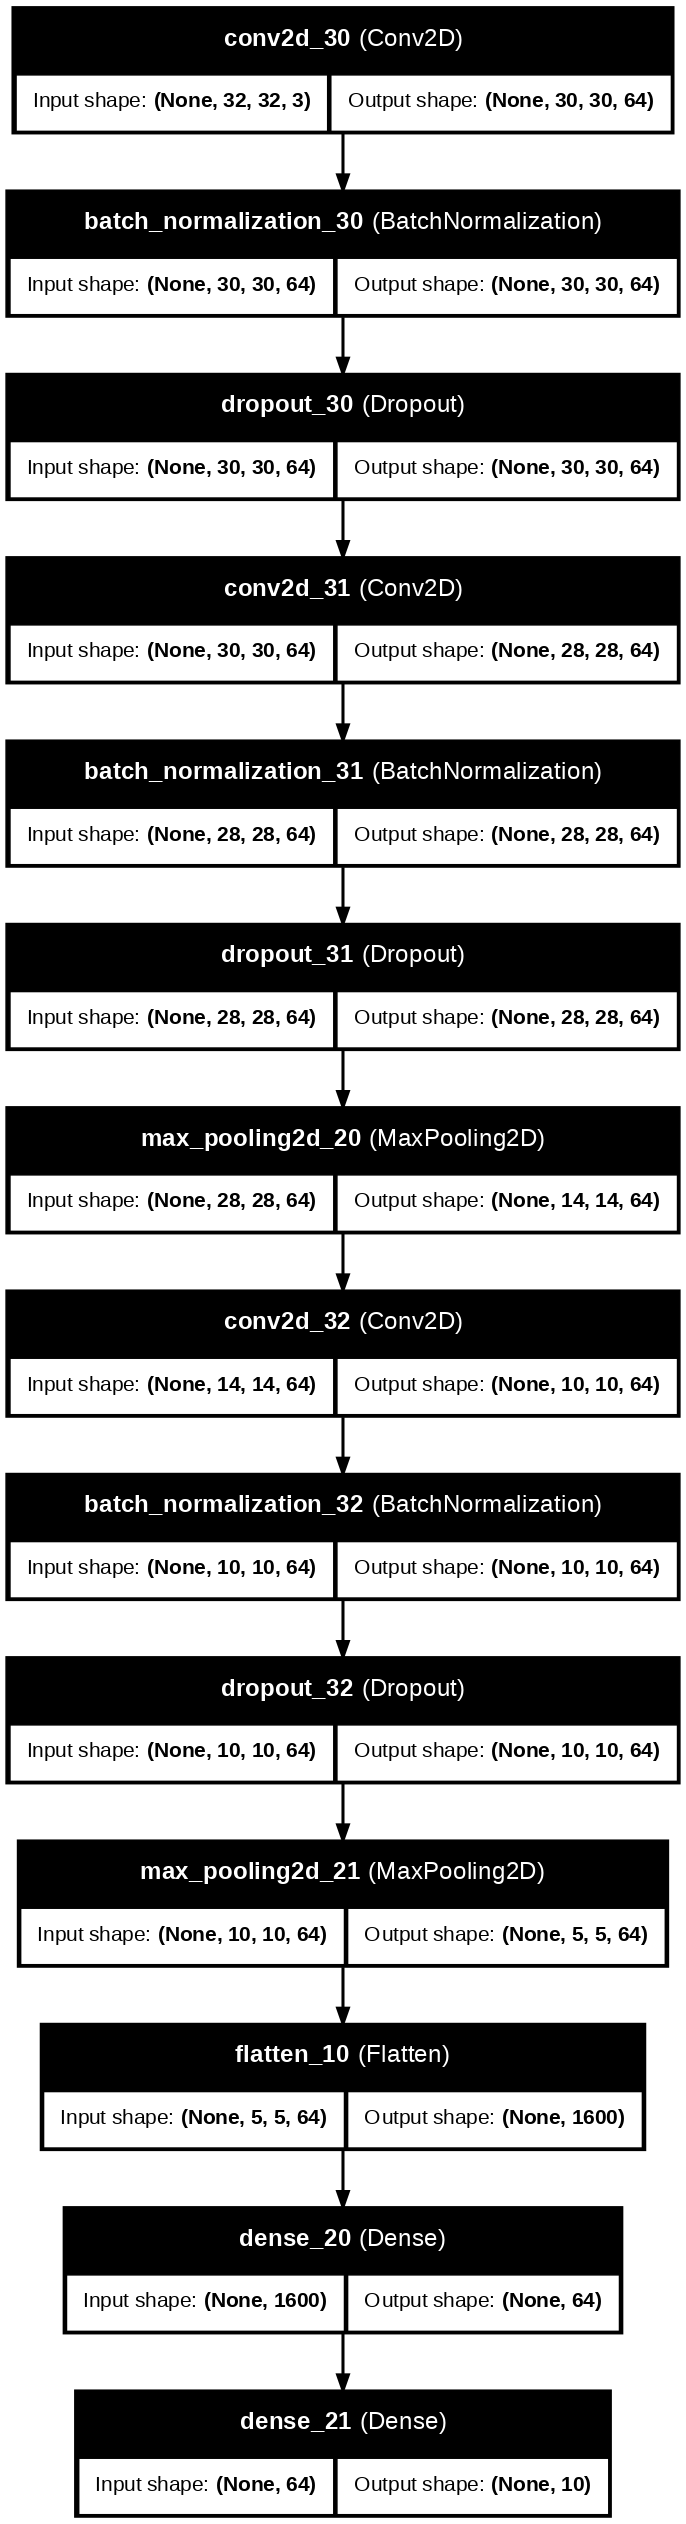

In [15]:
# diagram
plot_model(modelA, to_file="modelA.png", show_shapes=True, show_layer_names=True, dpi=110)
display(Image(filename="modelA.png", retina=True))

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.2650 - loss: 2.2307 - val_accuracy: 0.1061 - val_loss: 3.2788 - learning_rate: 1.0000e-04
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.4355 - loss: 1.5670 - val_accuracy: 0.2864 - val_loss: 2.2140 - learning_rate: 1.0000e-04
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5010 - loss: 1.4060 - val_accuracy: 0.4538 - val_loss: 1.5326 - learning_rate: 1.0000e-04
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5403 - loss: 1.2829 - val_accuracy: 0.4904 - val_loss: 1.4768 - learning_rate: 1.0000e-04
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5766 - loss: 1.2013 - val_accuracy: 0.5358 - val_loss: 1.3320 - learning_rate: 1.0000e-04
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6080 - loss: 1.1134 - val_accuracy: 0.5501 - val_loss: 1.3087 - learning_rate: 1.0000e-04
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/s

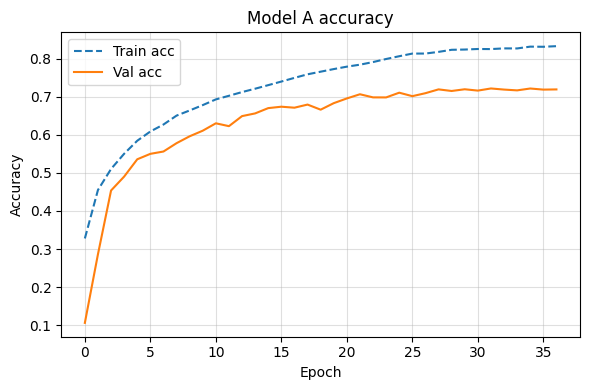

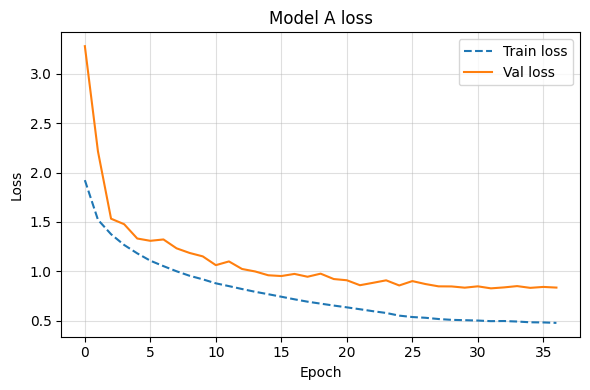

[Model A] Best val acc: 0.7218 | Test acc: 0.7199


In [35]:
# Train
th = TimeHistory()
histA = modelA.fit(
    X_train_norm, Y_train_cat,
    epochs=200,
    batch_size=bestA["batch"],
    validation_split=0.2,
    callbacks=[*cbs, th],
    verbose=1
)
print(f"[Model A] total training time: {th.total_time:.1f}s "
      f"(~{np.mean(th.epoch_times):.2f}s/epoch)")
# Plot accuracy (and loss if available)
H = histA.history
plt.figure(figsize=(6,4))
plt.plot(H["accuracy"], label="Train acc", linestyle="--")
plt.plot(H["val_accuracy"], label="Val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Model A accuracy")
plt.legend(); plt.grid(alpha=0.4); plt.tight_layout(); plt.show()

if "loss" in H and "val_loss" in H:
    plt.figure(figsize=(6,4))
    plt.plot(H["loss"], label="Train loss", linestyle="--")
    plt.plot(H["val_loss"], label="Val loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Model A loss")
    plt.legend(); plt.grid(alpha=0.4); plt.tight_layout(); plt.show()

# 7) Evaluate on test set
test_loss_A, test_acc_A = modelA.evaluate(X_test_norm, Y_test_cat, verbose=0)
print(f"[Model A] Best val acc: {max(H['val_accuracy']):.4f} | Test acc: {test_acc_A:.4f}")


## Model A — Final Results

**Setup (chosen hyperparams):** Adam (LR reduced to 1e-5 via ReduceLROnPlateau), He-uniform init, ReLU, dropout=0.0, filters=64, batch=128.

**Metrics**
- **Best validation accuracy:** 0.7218
- **Test accuracy:** 0.7199
- **Final train accuracy (last epoch):** 0.8312
- **Train–Val gap:** 0.1119 (0.8312 − 0.7193) → moderate overfitting
- **Val–Test gap:** 0.0019 (0.7218 − 0.7199) → excellent generalization
- **Training time:** ~220 s (≈ 5.94 s/epoch, 37 epochs)

**Learning curves**
- Val loss steadily decreases and stabilizes; val accuracy plateaus around 0.72.
- No late-epoch divergence between train/val curves; LR annealed to 1e-5 near the end.

**Conclusion**
- The model generalizes well (val ≈ test), with a manageable train–val gap for this architecture.
- This run is a solid baseline for reporting and future tweaks.


## Model B

In [36]:
# --- Model B (Functional) ---
bestB = {
    "optimizer": "SGD",
    "learn_rate": 1e-3,
    "init_mode": "he_uniform",
    "activation": "relu",
    "dropout_rate": 0.1,
    "filters": 32,
    "batch": 128,
}

# Build & train (uses your existing func_network builder)
modelB = func_network(
    bestB["optimizer"],
    bestB["learn_rate"],
    bestB["init_mode"],
    bestB["activation"],
    bestB["dropout_rate"],
    bestB["filters"],
)

# Ensure the learning rate is actually applied
opt = tf.keras.optimizers.get(
    {"class_name": bestB["optimizer"], "config": {"learning_rate": bestB["learn_rate"]}}
)
# keep current loss/metrics, just swap optimizer to ensure LR is set
modelB.compile(optimizer=opt, loss=modelB.loss, metrics=['accuracy'])

# Callbacks
cbs = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, mode="max", restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-5, mode="max", verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath="modelA_best.weights.h5", monitor="val_accuracy",
                                       mode="max", save_best_only=True, save_weights_only=True)
]

# Model summary
modelB.summary()

Optimizer: SGD  Learning rate: 0.001  Initiation mode: he_uniform  Activation: relu  Dropout rate: 0.1  Number of filters: 32


Model: "functional_318"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_86 (Conv2D)  │ (None, 30, 30,    │        896 │ input_layer_32[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        128 │ conv2d_86[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_87 (Conv2D)  │ (None, 28, 28,    │      2,432 │ input_layer_32[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_86          │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_87          │ (None, 28, 28,    │          0 │ conv2d_87[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_64    │ (None, 15, 15,    │          0 │ dropout_86[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_65    │ (None, 14, 14,    │          0 │ dropout_87[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_42          │ (None, 7200)      │          0 │ max_pooling2d_64… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_43          │ (None, 6272)      │          0 │ max_pooling2d_65… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 13472)     │          0 │ flatten_42[0][0], │
│ (Concatenate)       │                   │            │ flatten_43[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 64)        │    862,272 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_65 (Dense)    │ (None, 10)        │        650 │ dense_64[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 866,378 (3.30 MB)

 Trainable params: 866,314 (3.30 MB)

 Non-trainable params: 64 (256.00 B)

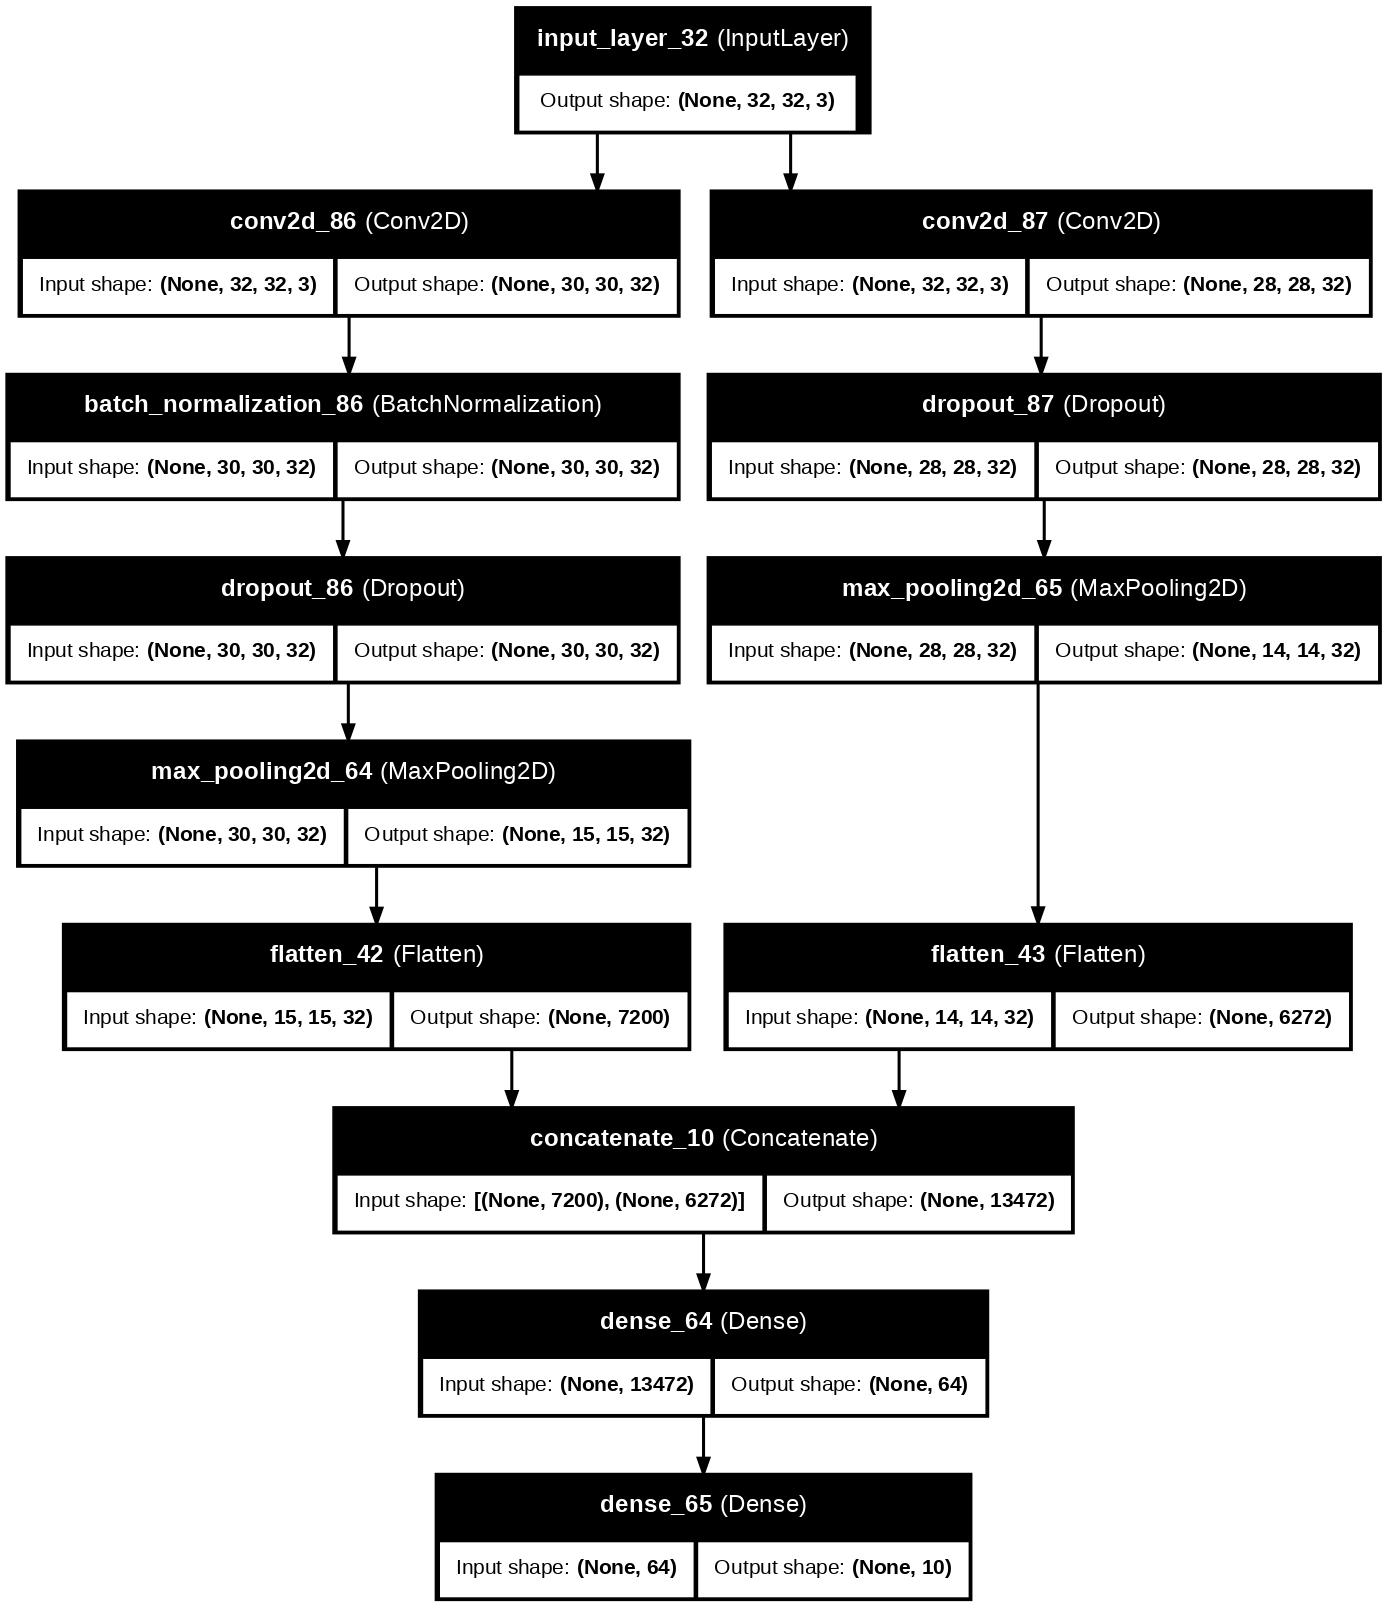

In [37]:
# Diagram
plot_model(modelB, to_file="modelB.png", show_shapes=True, show_layer_names=True, dpi=110)
display(Image(filename="modelB.png", retina=True))

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.2213 - loss: 2.1852 - val_accuracy: 0.3150 - val_loss: 1.9096 - learning_rate: 0.0010
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3875 - loss: 1.7432 - val_accuracy: 0.4106 - val_loss: 1.6718 - learning_rate: 0.0010
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4403 - loss: 1.5994 - val_accuracy: 0.4399 - val_loss: 1.5934 - learning_rate: 0.0010
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4627 - loss: 1.5371 - val_accuracy: 0.4634 - val_loss: 1.5359 - learning_rate: 0.0010
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4871 - loss: 1.4652 - val_accuracy: 0.4725 - val_loss: 1.4967 - learning_rate: 0.0010
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5077 - loss: 1.4071 - val_accuracy: 0.4920 - val_loss: 1.4529 - learning_rate: 0.0010
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5245 - loss: 

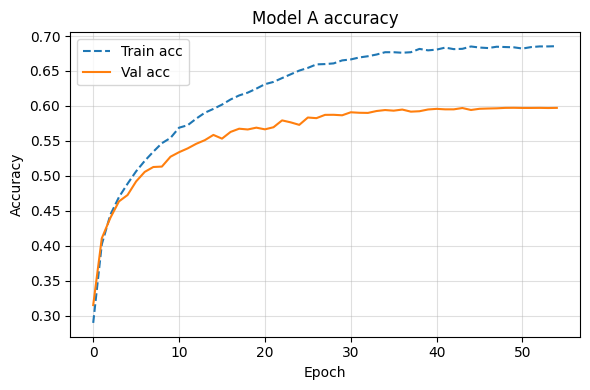

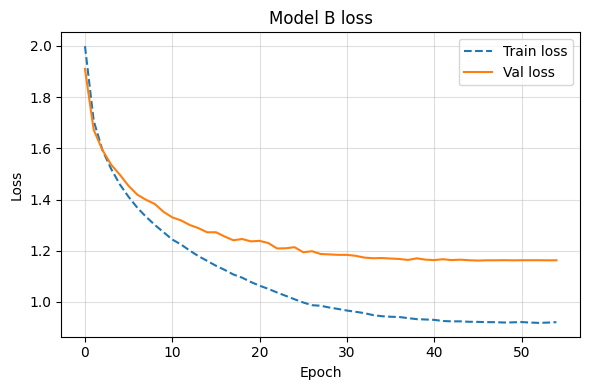

[Model B] Best val acc: 0.5973 | Test acc: 0.5944


In [38]:
# Train
th = TimeHistory()
histB = modelB.fit(
    X_train_norm, Y_train_cat,
    epochs=200,
    batch_size=bestA["batch"],
    validation_split=0.2,
    callbacks=[*cbs, th],
    verbose=1
)
print(f"[Model A] total training time: {th.total_time:.1f}s "
      f"(~{np.mean(th.epoch_times):.2f}s/epoch)")
# Plot accuracy (and loss if available)
J = histB.history
plt.figure(figsize=(6,4))
plt.plot(J["accuracy"], label="Train acc", linestyle="--")
plt.plot(J["val_accuracy"], label="Val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Model A accuracy")
plt.legend(); plt.grid(alpha=0.4); plt.tight_layout(); plt.show()

if "loss" in J and "val_loss" in J:
    plt.figure(figsize=(6,4))
    plt.plot(J["loss"], label="Train loss", linestyle="--")
    plt.plot(J["val_loss"], label="Val loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Model B loss")
    plt.legend(); plt.grid(alpha=0.4); plt.tight_layout(); plt.show()

# Evaluate on test set
test_loss_B, test_acc_B = modelB.evaluate(X_test_norm, Y_test_cat, verbose=0)
print(f"[Model B] Best val acc: {max(J['val_accuracy']):.4f} | Test acc: {test_acc_B:.4f}")

## Model B — Final Results

**Setup (chosen hyperparams):** (as in best Trial 9/1 runs for B).  
**Training:** EarlyStopping + ReduceLROnPlateau + checkpointing.

**Metrics**
- **Best validation accuracy:** 0.5973
- **Test accuracy:** 0.5944
- **Final train accuracy (last epoch):** 0.6837
- **Train–Val gap:** 0.0865 (0.6837 − 0.5972) → modest overfitting
- **Val–Test gap:** 0.0029 (0.5973 − 0.5944) → excellent generalization
- **Training time:** ~142.3 s (≈ 2.58 s/epoch, ~55 epochs)

**Learning curves**
- Val loss decreases steadily and flattens; val accuracy plateaus around 0.60.
- Gap between train/val is stable and relatively small compared to earlier searches.

**Conclusion**
- Model B generalizes well (val ≈ test) and trains faster per epoch than Model A.
- Absolute accuracy is lower than Model A’s best (~0.72), but B is efficient and stable.  
- If you value speed, B is a good choice; for higher accuracy, prefer Model A.


## Model A vs Model B — Comparison & Conclusions

### Summary table
| Metric | **Model A (Sequential)** | **Model B (Functional)** |
|---|---:|---:|
| Best **val acc** | **0.7218** | 0.5973 |
| **Test acc** | **0.7199** | 0.5944 |
| **Train–Val gap** | 0.1119 | **0.0865** |
| **Val–Test gap** | **0.0019** | 0.0029 |
| Epochs (final run) | ~37 | ~55 |
| ~Seconds / epoch | ~5.94 s | **~2.58 s** |
| Total train time | ~220 s | **~142 s** |

### What this says
- **Accuracy:** Model A wins by ~**+0.125** absolute on both validation and test (0.72 vs 0.60).
- **Generalization:** Both generalize well (val ≈ test). Model B shows a **smaller train–val gap**, i.e., slightly less overfitting.
- **Speed:** Model B is ~**2.3× faster per epoch** and finished the run ~**35% faster** overall.
- **Stability:** Learning curves are smooth for both; A reaches a higher plateau, B converges quickly but to a lower ceiling.

### When to choose which
- **Choose Model A** when **top accuracy** matters most (reports, benchmarks, final model).
- **Choose Model B** when **iteration speed** or **compute budget** is the priority (faster sweeps, prototyping).

### Practical next steps (no architecture changes)
- For **Model A:** aim to **shrink the train–val gap** without hurting accuracy  
  → try light augmentation, label smoothing (~0.05), AdamW + cosine decay, EMA/SWA, or very small dropout (0.1).
- For **Model B:** aim to **raise the accuracy ceiling**  
  → tune LR schedule (warmup + decay), consider Adam/AdamW at moderate LR, light augmentation; keep dropout light (≤0.2).

**Bottom line:**  
Model A is the **accuracy leader** with acceptable generalization; Model B is the **efficiency leader** with slightly better regularization but lower ceiling. Pick based on whether you value **accuracy** (A) or **training speed** (B).


# Conclusions

**Goal.** Compare two CNN architectures on CIFAR-10—**Model A (Sequential)** and **Model B (Functional)**—via  
1) random hyperparameter search, then 2) retraining with EarlyStopping, ReduceLROnPlateau, and checkpointing.

---

## What worked
- **Learning rate**
  - **Model A:** moderate LRs (≈1e-3→1e-4 with LR reductions) were strongest.
  - **Model B:** lower/moderate LRs (≈3e-4–1e-3) with SGD/RMSprop worked best.
- **Optimizers**
  - **A:** **Adam/RMSprop** consistently strong.
  - **B:** **SGD** (and some RMSprop runs) competitive.
- **Regularization**
  - With BatchNorm, **light or no dropout (0.0–0.2)** generally outperformed heavier dropout.
- **Capacity**
  - **32–64 filters** were sufficient; tuning **optimizer/LR** mattered more than width.

---

## Best observed performance (final runs)
- **Model A (Sequential):** **val acc ≈ 0.7218**, **test acc ≈ 0.7199**  
  Train–Val gap ≈ **0.112** → moderate overfitting; **Val–Test gap ≈ 0.002** → excellent generalization.
- **Model B (Functional):** **val acc ≈ 0.5973**, **test acc ≈ 0.5944**  
  Train–Val gap ≈ **0.087** → modest overfitting; **Val–Test gap ≈ 0.003** → excellent generalization.

**Speed:** Model B trained **~2.3× faster per epoch** (~ 2.6 s/epoch) than Model A (~5.9 s/epoch).

---

## Why Model B can be faster despite similar/fewer params
Compute cost is dominated by **convolution FLOPs**, not parameter count.  
Model A performs more convolutions **before pooling** (including a 5×5), so it processes larger feature maps longer.  
Model B pools earlier per branch → more work on **downsampled** maps → **few**

## Next steps (no architecture changes)
- **For Model A (accuracy leader):** aim to **shrink the train–val gap** without losing accuracy  
  → light augmentation, **label smoothing (~0.05)**.
- **For Model B (efficiency leader):** aim to **raise the accuracy ceiling**  
  → tune LR schedule (warmup + decay), light augmentation; keep dropout light (≤0.2).

---

## Key takeaway
With matched losses and a robust training recipe, **Model A** delivers the **highest accuracy (~0.72 val / ~0.72 test)**, while **Model B** trains **faster** and shows slightly smaller overfitting but a lower accuracy ceiling (~0.60). Choose **A** for top accuracy; choose **B** for iteration speed or tighter compute budgets.
